# **Objective**- Apply GBDT and RandomForest on Amazon review datasets

#### **About the dataset**

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454 
* Number of users: 256,059 
* Number of products: 74,258 
* Timespan: Oct 1999 - Oct 2012 
* Number of Attributes/Columns in data: 10

##### **Attribute Information**:

1. Id ProductId - unique identifier for the product 
2. UserId - unqiue identifier for the user ProfileName 
3. HelpfulnessNumerator - number of users who found the review helpful 
4. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not 
5. Score - rating between 1 and 5 
6. Time - timestamp for the review 
7. Summary - brief summary of the review 
8. Text - text of the review

#### **Codes for--**

1. Applying GridSearchCV for hyperparameter tuning on RandomForestClassifier for all the four vectorizer- Bow, Tfidf, Avg word2vec and Tfidf word2vec.

2. Applying GridSearchCV for hyperparameter tuning on XGBClassifier for all the four vectorizer- Bow, Tfidf, Avg word2vec and Tfidf word2vec

## **1. Loading and preprocessing the data**

In [42]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import nltk
import xgboost as xgb
from nltk.corpus import stopwords

In [44]:
from datetime import datetime
import pickle

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
sql=sqlite3.connect('database.sqlite')  #loading sql data
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql)

In [47]:
#for changing score int value to positive (1) and negative (0) i.e only in two class
def posneg(x):
    if x<3:
        return 0
    else:
        return 1
score=data['Score']
data['Score']=score.map(posneg)

In [48]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']] 

In [49]:
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True) #droping the duplicates
data.shape

(364171, 10)

In [50]:
stop=set(stopwords.words('english'))

In [51]:

sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [52]:
#taking sample of data
sample_data=data.sort_values(['Time'])  #sorting data on time basis
sample_data=sample_data.iloc[:100000]
sample_score=sample_data['Score']

##### ** Observation- Taking first 100k datapoints**

In [53]:
#filtering sentence
import re
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [54]:
sample_data['Cleaned_text']=final_string  #creating a new column in sample_data

In [55]:
sample_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [56]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3, shuffle=False) #splitting the data

In [57]:
# this function plot mse vs C plot, predicting accuracy, confusion matrix and classification report

def all_plot(clf, x_train, y_train, x_test, y_test):
    #optimal base lerner
    base=clf.best_estimator_.get_params()['n_estimators']
    print('optimal n_estimators = ',base)
    print('**********************************************************************\n')
    
    #plot error vs C
    x_1=[]
    y_1=[]
    
    for x in clf.grid_scores_:
        x_1.append(x[0]['n_estimators'])
        y_1.append(1-x[1])
        
    plt.plot(x_1,y_1, label='l1')
    plt.xlabel('number of base learner')
    plt.ylabel('misclassification error')
    plt.title('base learner vs error')
    plt.legend()
    plt.show()
    print('**********************************************************************\n')
      
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    
    return accu, TNR, TPR, FPR, FNR

## **2. Bag of Words**

In [58]:
count_vect=CountVectorizer()
x_train_bow=count_vect.fit_transform(X.values)

In [59]:
x_test_bow=count_vect.transform(x_test.values)

In [60]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


### **2.1 Apply GridSearchCV on RandomForestClassifier for bag of words**

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [61]:

base_lerner=list(range(1,200,10))
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner}
clf=RandomForestClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [62]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
pickle.dump(clf,open('rf_bow.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.4min finished


duration =  0:24:41.058927


optimal n_estimators =  11
**********************************************************************



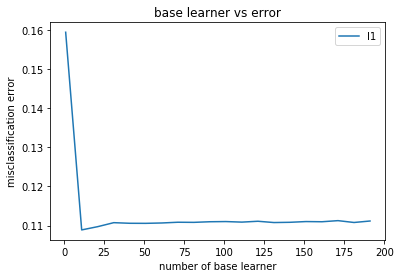

**********************************************************************

accuracy= 87.40333333333334
**********************************************************************

confusion matrix--


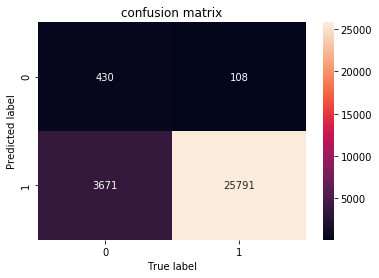

**********************************************************************

TNR= 0.10485247500609607
TPR= 0.9958299548245106
FPR= 0.8951475249939039
FNR= 0.0041700451754894015
**********************************************************************

             precision    recall  f1-score   support

          0       0.10      0.80      0.19       538
          1       1.00      0.88      0.93     29462

avg / total       0.98      0.87      0.92     30000

**********************************************************************



In [64]:
accu, TNR, TPR, FPR, FNR=all_plot(clf=clf, x_train=x_train_bow, x_test=x_test_bow, y_train=y_train, y_test=y_test)

**Feature Importance**

In [66]:
# feature importance
clf=RandomForestClassifier(n_estimators=11)
clf.fit(x_train_bow,y_train)


feature=count_vect.get_feature_names()
f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top features --')
print('*******************************************************')
for i in range(25):
    print(feature[index[i]],'\t\t:\t\t',round(f_imp[index[i]],5))

Top features --
*******************************************************
horribl 		:		 0.00298
even 		:		 0.00307
flavor 		:		 0.00314
use 		:		 0.0032
terribl 		:		 0.00336
tri 		:		 0.00345
buy 		:		 0.00349
stale 		:		 0.00355
bad 		:		 0.00356
one 		:		 0.00359
thought 		:		 0.00382
return 		:		 0.00408
good 		:		 0.00409
best 		:		 0.0045
didnt 		:		 0.00469
would 		:		 0.00476
product 		:		 0.00482
threw 		:		 0.00599
like 		:		 0.00635
wast 		:		 0.0064
disappoint 		:		 0.00674
worst 		:		 0.00725
great 		:		 0.00752
love 		:		 0.00804
tast 		:		 0.00834


### **2.2 Apply GridSearchCV on XGBClassifier for bag of words**

##### **XGBClassifier--**Implementation of the scikit-learn API for XGBoost classification.
https://xgboost.readthedocs.io/en/latest/python/python_api.html

##### **Ques. -> Why XGBoost instead of Sklearn gradient boosted trees?**
* XGBoost is a lot faster (see http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) than sklearn's. XGBoost is quite memory-efficient and can be parallelized


In [67]:
import xgboost as xgb

In [68]:

base_lerner=list(range(1,200,15))
max_depth=[1, 2, 3, 4, 5, 6, 7]
lr_rate=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth, 'learning_rate':lr_rate}
clf=xgb.XGBClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [ ]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
pickle.dump(clf,open('rf_bow_gbdt.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
Fitting 10 folds for each of 686 candidates, totalling 6860 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed: 62.1min
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 6860 out of 6860 | elapsed: 86.6min finished


duration =  1:27:19.189822


In [70]:
base=clf.best_estimator_.get_params()['n_estimators']
lr_rate=clf.best_estimator_.get_params()['learning_rate']
max_depth=clf.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',max_depth)
print('optimal learning rate = ',lr_rate)

optimal n_estimators =  181
optimal max_depth =  4
optimal learning rate =  0.5


accuracy= 90.40666666666667
**********************************************************************

confusion matrix--


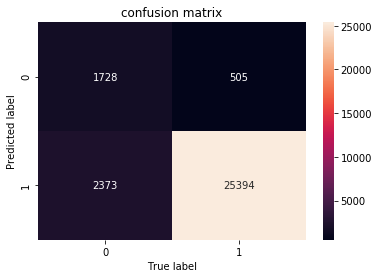

**********************************************************************

TNR= 0.4213606437454279
TPR= 0.9805011776516468
FPR= 0.5786393562545721
FNR= 0.019498822348353217
**********************************************************************



In [71]:
y_pred=clf.predict(x_test_bow)
accu=accuracy_score(y_pred,y_test)*100
print('accuracy=',accu)
print('**********************************************************************\n')
    
#confusion matrix
t=confusion_matrix(y_pred,y_test)
print('confusion matrix--')
#print(t)
#print('**********************************************************************')
sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('confusion matrix')
plt.show()
print('**********************************************************************\n')
    
# finding TPR , TNR, FPR, FNR
TNR=t[0][0]/(t[0][0]+t[1][0])
TPR=t[1][1]/(t[0][1]+t[1][1])
FPR=t[1][0]/(t[0][0]+t[1][0])
FNR=t[0][1]/(t[0][1]+t[1][1])
print('TNR=',TNR)
print('TPR=',TPR)
print('FPR=',FPR)
print('FNR=',FNR)
print('**********************************************************************\n')
    

**Feature Importance**

In [72]:
#feature importance
clf=xgb.XGBClassifier(n_estimators=181, max_depth=4, learning_rate=0.5)
clf.fit(x_train_bow,y_train)

feature=count_vect.get_feature_names()
f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top features --')
print('*******************************************************')
for i in range(25):
    print(feature[index[i]],'\t\t:\t\t',f_imp[index[i]],5)

Top features --
*******************************************************
thought 		:		 0.00524659
better 		:		 0.00524659
disappoint 		:		 0.0057712486
ive 		:		 0.0057712486
dont 		:		 0.006295908
much 		:		 0.006295908
think 		:		 0.006295908
realli 		:		 0.0068205665
order 		:		 0.0068205665
make 		:		 0.0073452257
littl 		:		 0.0073452257
look 		:		 0.007869884
get 		:		 0.008919203
flavor 		:		 0.009443861
great 		:		 0.00996852
use 		:		 0.013116474
buy 		:		 0.013116474
tri 		:		 0.013641133
product 		:		 0.014165793
love 		:		 0.014165793
one 		:		 0.014165793
good 		:		 0.017313747
would 		:		 0.019412382
tast 		:		 0.023084994
like 		:		 0.03043022


## **3. TFIDF**

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test)

In [75]:
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

### **3.1 Apply GridSearchCV on RandomForestClassifier for TFIDF**

In [76]:

base_lerner=list(range(1,200,10))
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner}
clf=RandomForestClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [77]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
pickle.dump(clf,open('rf_bow.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.5min finished


duration =  0:24:49.561960


optimal n_estimators =  11
**********************************************************************



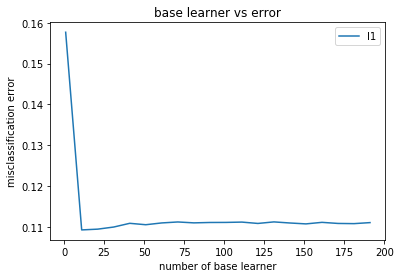

**********************************************************************

accuracy= 87.61
**********************************************************************

confusion matrix--


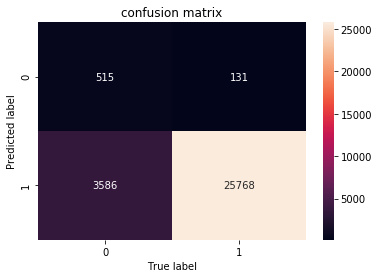

**********************************************************************

TNR= 0.12557912704218482
TPR= 0.9949418896482489
FPR= 0.8744208729578151
FNR= 0.005058110351751033
**********************************************************************

             precision    recall  f1-score   support

          0       0.13      0.80      0.22       646
          1       0.99      0.88      0.93     29354

avg / total       0.98      0.88      0.92     30000

**********************************************************************



In [78]:
accu, TNR, TPR, FPR, FNR=all_plot(clf=clf, x_train=x_train_tfidf, x_test=x_test_tfidf, y_train=y_train, y_test=y_test)

**Feature Importance**

In [79]:
# feature importance
clf=RandomForestClassifier(n_estimators=11)
clf.fit(x_train_tfidf,y_train)


feature=count_vect.get_feature_names()
f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top features --')
print('*******************************************************')
for i in range(25):
    print(feature[index[i]],'\t\t:\t\t',round(f_imp[index[i]],5))

Top features --
*******************************************************
make 		:		 0.00308
thought 		:		 0.00318
tri 		:		 0.00326
bad 		:		 0.00329
receiv 		:		 0.00333
mayb 		:		 0.00338
flavor 		:		 0.00341
one 		:		 0.0036
buy 		:		 0.00365
terribl 		:		 0.00374
best 		:		 0.00396
return 		:		 0.00396
money 		:		 0.0041
good 		:		 0.0042
didnt 		:		 0.0046
product 		:		 0.00483
like 		:		 0.0058
worst 		:		 0.00602
would 		:		 0.00607
love 		:		 0.0066
tast 		:		 0.00663
threw 		:		 0.00704
wast 		:		 0.00706
disappoint 		:		 0.00824
great 		:		 0.00846


### **3.2 Apply GridSearchCV on XGBClassifier for TFIDF**

In [80]:

base_lerner=list(range(1,200,15))
max_depth=[1, 2, 3, 4, 5, 6, 7]
lr_rate=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth, 'learning_rate':lr_rate}
clf=xgb.XGBClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [81]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
pickle.dump(clf,open('rf_tfidf_gbdt.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs
Fitting 10 folds for each of 686 candidates, totalling 6860 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed: 62.1min
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 6860 out of 6860 | elapsed: 86.5min finished


duration =  1:27:18.418037


In [82]:
base=clf.best_estimator_.get_params()['n_estimators']
lr_rate=clf.best_estimator_.get_params()['learning_rate']
max_depth=clf.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',max_depth)
print('optimal learning rate = ',lr_rate)

optimal n_estimators =  181
optimal max_depth =  4
optimal learning rate =  0.5


accuracy= 90.15333333333334
**********************************************************************

confusion matrix--


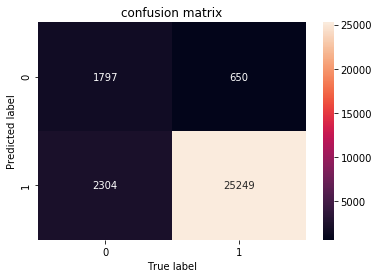

**********************************************************************

TNR= 0.4381858083394294
TPR= 0.9749025058882582
FPR= 0.5618141916605706
FNR= 0.025097494111741767
**********************************************************************



In [83]:
y_pred=clf.predict(x_test_tfidf)
accu=accuracy_score(y_pred,y_test)*100
print('accuracy=',accu)
print('**********************************************************************\n')
    
#confusion matrix
t=confusion_matrix(y_pred,y_test)
print('confusion matrix--')
#print(t)
#print('**********************************************************************')
sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('confusion matrix')
plt.show()
print('**********************************************************************\n')
    
# finding TPR , TNR, FPR, FNR
TNR=t[0][0]/(t[0][0]+t[1][0])
TPR=t[1][1]/(t[0][1]+t[1][1])
FPR=t[1][0]/(t[0][0]+t[1][0])
FNR=t[0][1]/(t[0][1]+t[1][1])
print('TNR=',TNR)
print('TPR=',TPR)
print('FPR=',FPR)
print('FNR=',FNR)
print('**********************************************************************\n')
    

**Feature Importance**

In [87]:
clf=xgb.XGBClassifier(n_estimators=181, max_depth=4, learning_rate=0.5)
clf.fit(x_train_tfidf,y_train)

feature=count_vect.get_feature_names()
f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top features --')
print('*******************************************************')
for i in range(25):
    print(feature[index[i]],'\t\t:\t\t',round(f_imp[index[i]],5))

Top features --
*******************************************************
much 		:		 0.00571
better 		:		 0.00571
bought 		:		 0.00622
bit 		:		 0.00622
doesnt 		:		 0.00622
look 		:		 0.00726
make 		:		 0.00778
time 		:		 0.00778
dont 		:		 0.0083
order 		:		 0.0083
littl 		:		 0.0083
buy 		:		 0.00882
find 		:		 0.00882
tri 		:		 0.01037
great 		:		 0.01089
flavor 		:		 0.01245
love 		:		 0.01297
use 		:		 0.01297
get 		:		 0.014
product 		:		 0.014
would 		:		 0.01504
one 		:		 0.01504
good 		:		 0.01763
tast 		:		 0.0249
like 		:		 0.02853


## **4. AVG Word2vec**

In [106]:
# taking first 25k points because for 100k points , parallel jobs do not work and takes lots of time for computing hyperparam even only for RF
sample_data=sample_data.iloc[:25000]
sample_score=sample_data['Score']

In [107]:
#filtering sentence
import re
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [108]:
sample_data['Cleaned_text']=final_string  #creating a new column in sample_data

In [109]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3, shuffle=False) #splitting the data

In [85]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [86]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-09-20 09:16:55,114 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-20 09:19:52,345 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [155]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        w=w.decode('utf-8')
        #if (w==sent.split()[0]):
            #w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [156]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [157]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [158]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[1960, 2226, 4436, 4524, 11064, 11967]

In [159]:
vectors=np.delete(vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [160]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        #if(word==sentence.split()[0]):
            #word=word[2:]
        word=word.decode('utf-8')
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [161]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[]

In [162]:
#deleting row containing nan value
x_test_word=np.delete(x_test_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

### **4.1 Apply GridSearchCV on RandomForestClassifier for Avg Word2vec**

In [121]:

base_lerner=list(range(1,200,10))
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner}
clf=RandomForestClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [122]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
pickle.dump(clf,open('rf_avg_rf.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


duration =  0:04:59.558824


optimal n_estimators =  71
**********************************************************************



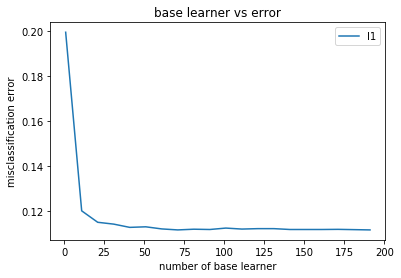

**********************************************************************

accuracy= 88.53333333333333
**********************************************************************

confusion matrix--


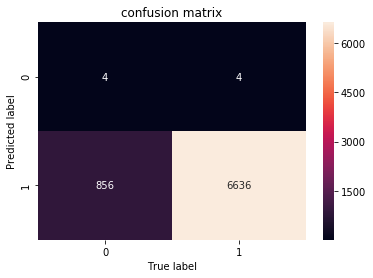

**********************************************************************

TNR= 0.004651162790697674
TPR= 0.9993975903614458
FPR= 0.9953488372093023
FNR= 0.0006024096385542169
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.50      0.01         8
          1       1.00      0.89      0.94      7492

avg / total       1.00      0.89      0.94      7500

**********************************************************************



In [123]:
accu, TNR, TPR, FPR, FNR=all_plot(clf=clf, x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [125]:
# feature importance
clf=RandomForestClassifier(n_estimators=71)
clf.fit(vectors,y_train_word)

f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top 25 features IG --')
print('*******************************************************')
for i in range(25):
    print(round(f_imp[index[i]],5))

Top 25 features IG --
*******************************************************
0.00449
0.00466
0.00469
0.00479
0.00483
0.00491
0.00501
0.00514
0.00531
0.00534
0.00538
0.00555
0.00558
0.00567
0.00568
0.00574
0.00693
0.00701
0.00707
0.00711
0.00719
0.00863
0.00888
0.00904
0.01006


### **4.2 Apply GridSearchCV on XGBClassifier for Avg Word2vec**

In [128]:

base_lerner=list(range(1,200,15))
max_depth=[1, 2, 3, 4, 5, 6, 7]
lr_rate=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth, 'learning_rate':lr_rate}
clf=xgb.XGBClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [129]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
pickle.dump(clf,open('rf_avg_xgboost.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs
Fitting 10 folds for each of 686 candidates, totalling 6860 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed: 98.2min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed: 123.4min
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed: 147.6min
[Parallel(n_jobs=-1)]: Done 6860 out of 6860 | elapsed: 168.4min finished


duration =  2:51:00.266846


In [130]:
base=clf.best_estimator_.get_params()['n_estimators']
lr_rate=clf.best_estimator_.get_params()['learning_rate']
max_depth=clf.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',max_depth)
print('optimal learning rate = ',lr_rate)

optimal n_estimators =  181
optimal max_depth =  7
optimal learning rate =  0.5


accuracy= 89.46666666666667
**********************************************************************

confusion matrix--


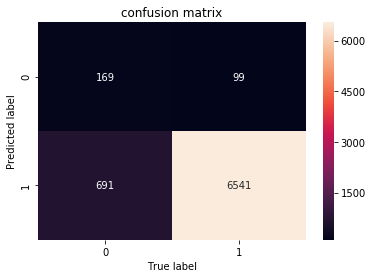

**********************************************************************

TNR= 0.19651162790697674
TPR= 0.9850903614457831
FPR= 0.8034883720930233
FNR= 0.014909638554216868
**********************************************************************



In [132]:
y_pred=clf.predict(x_test_word)
accu=accuracy_score(y_pred,y_test_word)*100
print('accuracy=',accu)
print('**********************************************************************\n')
    
#confusion matrix
t=confusion_matrix(y_pred,y_test_word)
print('confusion matrix--')
#print(t)
#print('**********************************************************************')
sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('confusion matrix')
plt.show()
print('**********************************************************************\n')
    
# finding TPR , TNR, FPR, FNR
TNR=t[0][0]/(t[0][0]+t[1][0])
TPR=t[1][1]/(t[0][1]+t[1][1])
FPR=t[1][0]/(t[0][0]+t[1][0])
FNR=t[0][1]/(t[0][1]+t[1][1])
print('TNR=',TNR)
print('TPR=',TPR)
print('FPR=',FPR)
print('FNR=',FNR)
print('**********************************************************************\n')
    

**Feature Importance**

In [163]:
# feature importance
clf=xgb.XGBClassifier(n_estimators=181, max_depth=7, learning_rate=0.5)
clf.fit(vectors,y_train_word)

f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top 25 features IG --')
print('*******************************************************')
for i in range(25):
    print(round(f_imp[index[i]],5))

Top 25 features IG --
*******************************************************
0.00489
0.00504
0.00504
0.00504
0.00504
0.00504
0.00504
0.00519
0.00519
0.00519
0.00548
0.00548
0.00548
0.00548
0.00563
0.00578
0.00578
0.00578
0.00593
0.00593
0.00607
0.00652
0.00696
0.00785
0.00933


## **5. TFIDF Word2vec**

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [134]:
features=tfidf.get_feature_names()
len(features)
#features

15151

In [135]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [136]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[1960, 2226, 4436, 4524, 11064, 11967]

In [137]:

y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)



In [140]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        #if(word==sentence.split()[0]):
           # word=word[2:]
        word=word.decode('utf-8')
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [141]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[]

In [142]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

7500

In [143]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(x_test_word)

7500

### **5.1 Apply GridSearchCV on RandomForestClassifier for Tfidf Word2vec**

In [144]:

base_lerner=list(range(1,200,10))
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner}
clf=RandomForestClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [145]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
pickle.dump(clf,open('rf_tfavg_xgboost.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.5 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


duration =  0:05:47.533767


optimal n_estimators =  111
**********************************************************************



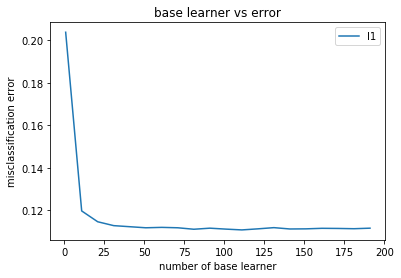

**********************************************************************

accuracy= 88.53333333333333
**********************************************************************

confusion matrix--


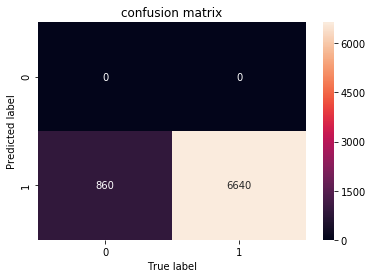

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.89      0.94      7500

avg / total       1.00      0.89      0.94      7500

**********************************************************************



In [146]:
accu, TNR, TPR, FPR, FNR=all_plot(clf=clf, x_train=tfidf_vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

**Feature Importance**

In [153]:
# feature importance
clf=RandomForestClassifier(n_estimators=111)
clf.fit(tfidf_vectors,y_train_word)

f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top 25 features IG --')
print('*******************************************************')
for i in range(25):
    print(round(f_imp[index[i]],5))

Top 25 features IG --
*******************************************************
0.00457
0.00458
0.00459
0.00462
0.00463
0.00472
0.00474
0.00479
0.0049
0.00493
0.00509
0.00509
0.00515
0.00516
0.00517
0.00547
0.00551
0.00551
0.0056
0.00564
0.0058
0.00674
0.00711
0.00712
0.00795


### **5.2 Apply GridSearchCV on XGBClassifier for Tfidf Word2vec**

In [147]:

base_lerner=list(range(1,200,15))
max_depth=[1, 2, 3, 4, 5, 6, 7]
lr_rate=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
tscv=TimeSeriesSplit(n_splits=10)
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth, 'learning_rate':lr_rate}
clf=xgb.XGBClassifier()
clf=GridSearchCV(estimator=clf, param_grid=hyperparam, cv=tscv, n_jobs=-1, verbose=1)


In [148]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
pickle.dump(clf,open('rf_tfavg_xgboost_real.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 686 candidates, totalling 6860 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed: 98.6min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed: 124.0min
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed: 148.7min
[Parallel(n_jobs=-1)]: Done 6860 out of 6860 | elapsed: 170.1min finished


duration =  2:52:36.990539


In [149]:
base=clf.best_estimator_.get_params()['n_estimators']
lr_rate=clf.best_estimator_.get_params()['learning_rate']
max_depth=clf.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',max_depth)
print('optimal learning rate = ',lr_rate)

optimal n_estimators =  196
optimal max_depth =  5
optimal learning rate =  0.1


accuracy= 89.25333333333333
**********************************************************************

confusion matrix--


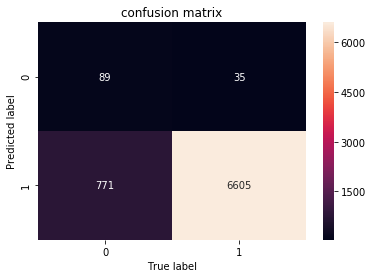

**********************************************************************

TNR= 0.10348837209302325
TPR= 0.9947289156626506
FPR= 0.8965116279069767
FNR= 0.005271084337349397
**********************************************************************



In [150]:
y_pred=clf.predict(x_test_word)
accu=accuracy_score(y_pred,y_test_word)*100
print('accuracy=',accu)
print('**********************************************************************\n')
    
#confusion matrix
t=confusion_matrix(y_pred,y_test_word)
print('confusion matrix--')
#print(t)
#print('**********************************************************************')
sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('confusion matrix')
plt.show()
print('**********************************************************************\n')
    
# finding TPR , TNR, FPR, FNR
TNR=t[0][0]/(t[0][0]+t[1][0])
TPR=t[1][1]/(t[0][1]+t[1][1])
FPR=t[1][0]/(t[0][0]+t[1][0])
FNR=t[0][1]/(t[0][1]+t[1][1])
print('TNR=',TNR)
print('TPR=',TPR)
print('FPR=',FPR)
print('FNR=',FNR)
print('**********************************************************************\n')
    

**Feature Importance**

In [154]:
# feature importance
clf=xgb.XGBClassifier(n_estimators=196, learning_rate=0.1, max_depth=5)
clf.fit(tfidf_vectors,y_train_word)

f_imp=clf.feature_importances_
index=np.argsort(f_imp)[-25:]
print('Top 25 features IG --')
print('*******************************************************')
for i in range(25):
    print(round(f_imp[index[i]],5))

Top 25 features IG --
*******************************************************
0.00619
0.00637
0.00637
0.00655
0.00655
0.00673
0.00673
0.00673
0.00673
0.0069
0.00708
0.00708
0.00726
0.00726
0.00743
0.00761
0.00761
0.00761
0.00779
0.00796
0.00832
0.00867
0.01009
0.01062
0.01239


## **6. Performance Table**

| sno | featurization | model algo | cv algo | best n_estimators | accuracy | TNR | TPR | 
|-----|----------------|------------------------|--------------|-------------------|----------|--------|--------|
| 1 | BoW | RandomForestClassifier | GridSearchCV | 11 | 87.4033 | 0.1048 | 0.9958 | 
| 2 | TFIDF | RandomForestClassifier | GridSearchCV | 11 | 87.61 | 0.1255 | 0.9949 | 
| 3 | Avg word2vec | RandomForestClassifier | GridSearchCV | 71 | 88.5333 | 0.0046 | 0.9993 | 
| 4 | Tfidf word2vec | RandomForestClassifier | GridSearchCV | 111 | 88.5333 | 0.0 | 1.0 | 

**************************************************************************************************************

| sno | featurization | model algo | cv algo | best n_estimators | best max_depth | best learning rate | accuracy | TNR | TPR |
|-----|----------------|---------------|--------------|-------------------|----------------|--------------------|----------|--------|--------|
| 1 | BoW | XGBClassifier | GridSearchCV | 181 | 4 | 0.5 | 90.4066 | 0.4213 | 0.9805 |
| 2 | TFIDF | XGBClassifier | GridSearchCV | 181 | 4 | 0.5 | 90.1533 | 0.4381 | 0.9749 |
| 3 | Avg word2vec | XGBClassifier | GridSearchCV | 181 | 7 | 0.5 | 89.4666 | 0.1965 | 0.9850 |
| 4 | Tfidf word2vec | XGBClassifier | GridSearchCV | 196 | 5 | 0.1 | 89.2533 | 0.1034 | 0.9947 |

## **Conclusion--**
1. We have used RandomForestClassifier and XGBClassifier on amazon food review dataset.
2. We have used GridSearchCV for finding the best hyperparameter.
3. In the performance table, we can see that RandomForestClassifier does not work well as TNR for all the vectorizer used is very less.
4. XGBClassifier for BoW and Tfidf gives good accuracy as well as good TNR.
5. Here XGBClassifier works better than RandomForestClassfier in the case of amazon dataset.